In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import time

import pandas as pd

In [2]:
path = "/home/borowis/s3"
bs = 512

In [3]:
trans = transforms.Compose([
    transforms.RandomAffine(10, shear=5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = ImageFolder(path + "/train_data/medium", trans)
train_loader = DataLoader(train_data, bs, shuffle=True, num_workers=8)

In [4]:
val_data = ImageFolder(path + "/validation_classification/medium", trans)
val_loader = DataLoader(val_data, bs, shuffle=True, num_workers=8)

In [5]:
class SimpleNet(nn.Module):
        
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.05))

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.drop_out1 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 4096)
        self.bc1 = nn.BatchNorm1d(4096)
        self.ac1 = nn.ReLU()
        
        self.drop_out2 = nn.Dropout()
        self.fc2 = nn.Linear(4096, 2300)
        
    def forward(self, x):
        
        x = self.layer1(x) #32
        x = self.layer2(x) #16
        x = self.layer3(x) #16
        x = self.layer4(x) #8
        x = self.layer5(x) #4
        x = self.layer6(x) #4

        #Reshape data to input to the input layer of the neural net
        #Size changes from (128, 4, 4) to (1, 2048)
        x = x.view(-1, 128 * 4 * 4)
        x = self.drop_out1(x)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 2048) to (1, 2300)
        x = self.fc1(x)
        x = self.bc1(x)
        x = self.ac1(x)
        
        x = self.drop_out2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [6]:
model = SimpleNet()

criterion = nn.CrossEntropyLoss()
print(model)

optimizer = optim.Adam(model.parameters())

SimpleNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.05)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2,

In [7]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.cuda()
        target = target.long().cuda()

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [8]:
def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.cuda()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.long().cuda()

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Loss: ', running_loss)
        print('Validation Accuracy: ', acc, '%')
        return running_loss, acc

In [9]:
n_epochs = 3
train_loss = []
val_loss = []
val_acc = []

In [13]:
for i in range(10, 13):
    tl = train_epoch(model, train_loader, criterion, optimizer)
    vl, va = test_model(model, val_loader, criterion)
    
    train_loss.append(tl)
    val_loss.append(vl)
    val_acc.append(va)
    print('='*20)
    
    # https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/16
    torch.save({
        'epoch': i + 1,
        'state_dict': model.state_dict(),
        'best_acc': val_acc,
        'optimizer' : optimizer.state_dict(),
    }, path + "/models/" + str(i) + ".pth")

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss:  1.4987630571701458 Time:  183.01639556884766 s
Validation Loss:  1.5206388102637396
Validation Accuracy:  68.0721582264725 %
Training Loss:  1.4374264045195146 Time:  183.00909614562988 s
Validation Loss:  1.5180846717622545
Validation Accuracy:  68.65898717670072 %
Training Loss:  1.3841626798527624 Time:  183.2315468788147 s
Validation Loss:  1.5017294618818495
Validation Accuracy:  68.52858074331667 %


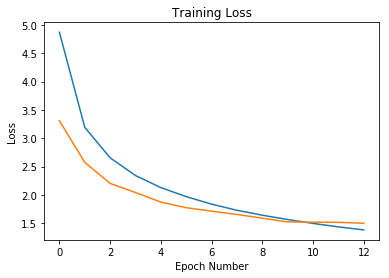

In [14]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

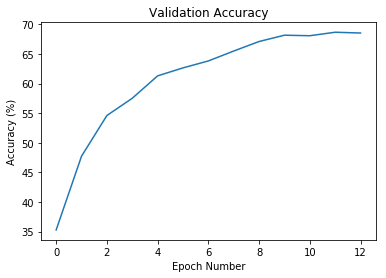

In [15]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(val_acc)

In [16]:
checkpoint = torch.load(path + "/models/9.pth")
model.load_state_dict(checkpoint["state_dict"])

In [17]:
test_trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_data = ImageFolder(path + "/test_classification", test_trans)
test_loader = DataLoader(test_data, shuffle = False, batch_size = bs, num_workers = 8)

In [18]:
def inference(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.cuda()

        preds = []
        for batch_idx, data in enumerate(test_loader):   
            data = data[0].cuda()
            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())

        return np.concatenate(preds)

In [19]:
preds = inference(model, test_loader)

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [20]:
class_to_idx = train_data.class_to_idx
idx_to_class = {val: key for key, val in class_to_idx.items()}

In [21]:
ids = []
for idx, (pred, (file, _)) in enumerate(zip(preds, test_data.samples)):
    file_name = file[file.rfind('/') + 1 : file.rfind('.')]
    ids.append(int(file_name))

In [22]:
submit = pd.DataFrame({'label': preds}, index=ids)

submit.label = submit.label.map(idx_to_class)
submit.sort_index().head(20)

,label
0,1613
1,1364
2,1016
3,1425
4,505
5,1040
6,1952
7,711
8,816
9,940


In [23]:
submit.sort_index().to_csv(path + "/model3.csv", index=True, index_label='id')